# Lesson 15.2 学习率调度在PyTorch中的实现方法

学习率调度作为模型优化的重要方法，也集成了PyTorch的optim模块中。我们可以通过下述代码将学习率调度模块进行导入。

In [277]:
from torch.optim import lr_scheduler

接下来，我们从较为基础的学习率调度方法入手，熟悉PyTorch中实现学习率调度的基本思路与流程。

## 1. 优化器与状态字典（state_dict）

在此前的模型训练过程中，我们已经基本了解了PyTorch中的模型优化器的基本使用方法。模型优化器是求解损失函数的函数，其中包含了模型训练的诸多关键信息，包括模型参数，模型学习率等，同时在进行模型训练时，我们也是通过优化器调整模型参数，归零模型梯度。而在学习率调度过程中，由于我们需要动态调整学习率，而学习率又是通过传入优化器进而影响模型训练的，因此在利用PyTorch进行学习率调度的时候，核心需要考虑的问题是如何让优化器内的学习率随着迭代次数增加而不断变化。

为了做到这一点，首先我们需要补充关于优化器状态字典内容。

In [278]:
# 查看帮助
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchLearning import *

from torch.utils.tensorboard import SummaryWriter

# 一个cell输出多个结果
writer = SummaryWriter(log_dir= 'reg_loss')


In [279]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w= [2, -1, 3, 1, 2], bias= False, deg= 2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels, batch_size= 50)

In [280]:
# 设置随机数种子
torch.manual_seed(24)

# 实例化模型
tanh_model1 = net_class2(act_fun= torch.tanh, in_features= 5, BN_model= 'pre')

In [281]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(), lr= 0.5)

在优化器创建完成之后，我们可以使用.state_dict()方法查看优化器状态。

In [282]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.5,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

该方法会返回一个包含优化器核心信息的字典，目前为止该字典包含两个元素，第一个优化器状态（state），第二个是优化器相关数据簇（param_groups），其中，目前为止核心需要关注的是参数簇中的lr对象，该对象代表着下一次模型训练的时候所带入的学习率。当然，我们可以通过如下方法提取lr对应的value。

In [283]:
optimizer.state_dict()['param_groups']

[{'lr': 0.5,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False,
  'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]

In [284]:
optimizer.state_dict()['param_groups'][0]

{'lr': 0.5,
 'momentum': 0,
 'dampening': 0,
 'weight_decay': 0,
 'nesterov': False,
 'maximize': False,
 'foreach': None,
 'differentiable': False,
 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [285]:
optimizer.state_dict()['param_groups'][0]['lr']

0.5

> 参数簇中其他参数包括动量系数、特征权重、是否采用牛顿法及待训练参数索引。

另外，params表示训练参数个数（其中一个矩阵算作一个参数），可以通过如下方式进行简单验证。

In [286]:
list(tanh_model1.parameters())

[Parameter containing:
 tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
         [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
         [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
         [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]], requires_grad=True),
 Parameter containing:
 tensor([-0.3999, -0.2694,  0.2703, -0.3355], requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
         [ 0.2336, -0.3569, -0.1928, -0.1566],
         [ 0.4825, -0.4463,  0.3027,  0.4696],
         [ 0.3953,  0.2131,  0.2226, -0.0267]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2516,  0.4558, -0.1608,  0.4831], requires_grad=True),
 Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.07

In [287]:
# 验证带训练参数个数
len(list(tanh_model1.parameters()))

10

In [288]:
tanh_model2 = net_class3(act_fun= torch.tanh, in_features= 5, BN_model= 'pre')
optimizer = torch.optim.SGD(tanh_model2.parameters(), lr= 0.05)
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

In [289]:
len(list(tanh_model2.parameters()))

14

---

# 模型本地保存与读取方法

同时，借助state_dict()方法，我们可以实现模型或优化器的本地保存与读取。此处以模型为例，优化器的本地保存相关操作类似。

对于模型而言，其实也有stste_dict()方法。通过该方法的调用，可以查看模型全部参数信息。

> 值得注意的是，模型的训练和保存，本质上都是针对模型的参数。而模型的state_dict()则包含了模型当前全部的参数信息。因此，保存了模型的state_dict（）就相当于是保存了模型

In [290]:
tanh_model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

首先我们可以将存有模型全部参数信息的字典对象赋值给某个变量。

In [291]:
t1 = tanh_model1.state_dict()
t1

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

其次，我们也可以通过torch.save来将该参数保存至本地。

In [292]:
torch.save(tanh_model1.state_dict(), 'tanh1_pt')

对于torch.save函数来说，第一个参数就是需要保存的模型参数，而第二个参数则是保存到本地的文件名。一般来说可以令其后缀为.pt或者.pth。而当我们需要读取保存的参数结果时，则可以直接使用load_state_dict方法。该方法的使用我们稍后就会谈到。

接下来进行模型训练，也就是模型参数调整。回顾此前学习内容，当我们进行模型训练时，实际上就是借助损失函数和反向传播机制进行梯度求解，然后利用优化器根据梯度去更新各线性层参数。

In [293]:
criterion = nn.MSELoss()
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(), lr= 0.03)

In [294]:
for X, y in train_loader:
    yhat = tanh_model1.forward(X)
    loss = criterion(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

训练完一轮后，我们可以查看模型状态：

In [295]:
tanh_model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.2737, -0.0827, -0.3245,  0.0417,  0.4476],
                      [-0.0780, -0.0809,  0.4282,  0.0384, -0.2473],
                      [-0.0526,  0.0309, -0.3733, -0.0910,  0.4425],
                      [-0.1395,  0.4100, -0.0588, -0.1530, -0.2139]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([0.9595, 0.9127, 0.9882, 0.9982])),
             ('normalize1.bias', tensor([-0.0036, -0.1702, -0.0620,  0.0016])),
             ('normalize1.running_mean',
              tensor([-0.2898, -0.2090,  0.2033, -0.2799])),
             ('normalize1.running_var',
              tensor([0.5230, 0.4083, 0.4951, 0.4024])),
             ('normalize1.num_batches_tracked', tensor(14)),
             ('linear2.weight',
              tensor([[ 0.2171,  0.4067, -0.0237,  0.2157],
                      [ 0.0549, -0.1504, -0.2637, -0.0938],
                      [ 0.3110, -0.2425,  

我们发现模型的参数已经发生了变化，此时，我们可以通过使用load_state_dict方法，将训练好的参数替换t1中保存的原tanh_model1中参数

In [296]:
tanh_model1.load_state_dict(t1)

<All keys matched successfully>

In [297]:
tanh_model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.2737, -0.0827, -0.3245,  0.0417,  0.4476],
                      [-0.0780, -0.0809,  0.4282,  0.0384, -0.2473],
                      [-0.0526,  0.0309, -0.3733, -0.0910,  0.4425],
                      [-0.1395,  0.4100, -0.0588, -0.1530, -0.2139]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([0.9595, 0.9127, 0.9882, 0.9982])),
             ('normalize1.bias', tensor([-0.0036, -0.1702, -0.0620,  0.0016])),
             ('normalize1.running_mean',
              tensor([-0.2898, -0.2090,  0.2033, -0.2799])),
             ('normalize1.running_var',
              tensor([0.5230, 0.4083, 0.4951, 0.4024])),
             ('normalize1.num_batches_tracked', tensor(14)),
             ('linear2.weight',
              tensor([[ 0.2171,  0.4067, -0.0237,  0.2157],
                      [ 0.0549, -0.1504, -0.2637, -0.0938],
                      [ 0.3110, -0.2425,  

此时t1保存的就是训练后的模型参数。当然，如果我们想还原会模型训练前的tanh_model1参数，则可使用以下方法：

In [298]:
torch.load('tanh1_pt')

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

In [299]:
tanh_model1.load_state_dict(torch.load('tanh1_pt'))

<All keys matched successfully>

In [300]:
tanh_model1.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.2365, -0.1118, -0.3801,  0.0275,  0.4168],
                      [-0.1995, -0.1456,  0.3497, -0.0622, -0.1708],
                      [-0.0901,  0.0164, -0.3643, -0.1278,  0.4336],
                      [-0.0959,  0.4073, -0.1746, -0.1799, -0.1333]])),
             ('linear1.bias', tensor([-0.3999, -0.2694,  0.2703, -0.3355])),
             ('normalize1.weight', tensor([1., 1., 1., 1.])),
             ('normalize1.bias', tensor([0., 0., 0., 0.])),
             ('normalize1.running_mean', tensor([0., 0., 0., 0.])),
             ('normalize1.running_var', tensor([1., 1., 1., 1.])),
             ('normalize1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.1708,  0.4704, -0.0635,  0.2187],
                      [ 0.2336, -0.3569, -0.1928, -0.1566],
                      [ 0.4825, -0.4463,  0.3027,  0.4696],
                      [ 0.3953,  0.2131,  0.2226, -0.0267]])),
             ('linea

至此，我们就完成了模型训练与保存的基本过程。当然，除了模型可以按照上述方法保存外，优化器也可以类似进行本地存储。

---

接下来，我们使用optim模块中lr_scheduler相关函数，来实现优化器中学习率的动态调整。

## 2. LambdaLR基本使用方法

让优化器动态调整学习率的类，也被我们称为学习率调度器类，该类实例化的对象也被称为学习率调度器。在所有的学习率调度器中，LambdaLR类时实现学习率调度最简单灵活、同时也是通用的一种方法。

要使用LambdaLR来完成学习率调度，首先需要准备一个lambda匿名函数，例如：

In [301]:
lr_lambda = lambda epoch: 0.5 ** epoch

此处我们通过lambda创建了一个匿名函数。该函数需要输入一个参数，一般来说我们会将该参数视作模型迭代次数。当然，上述匿名函数是个非常简答的匿名函数，输出结果就是0.5的epoch次方。

In [302]:
# 第一轮迭代时
lr_lambda(0)

1.0

In [303]:
## 第二轮迭代时
lr_lambda(1)

0.5

> 此处需要注意的是，一般来说epoch取值从0开始，并且用于学习率调度的匿名函数参数取值为0时，输出结果不能为0.

在准备好一个匿名函数之后，接下来我们需要实例化一个LanbdaLR学习率调度器。同时，由于所有的学习率调度器都是通过修改某个优化器来完成学习率调度，因此我们还需要创建一个对应的优化器（当然为了模型训练，也是要创建优化器的）。优化器的创建无须其它设置，该优化器的学习率调度器的关联主要是通过学习率调度器来体现。

In [304]:
# 设置随机数种子
torch.manual_seed(24)

# 实例化模型
tanh_model1 = net_class2(act_fun= torch.tanh, in_features= 5, BN_model= 'pre')

In [305]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(), lr= 0.05)

In [306]:
# 查看优化器信息
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [307]:
# 学习率调度器
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

注意，LambdaLR学习率调度器的创建必须要输入一个lambda函数和与之关联的优化器。一旦优化器创建完成，我们即可继续观察优化器optimizer的状态。

In [308]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

此时优化器的参数簇中多了'initial_lr'元素。该元素代表初始学习率，也就是我们在实例化优化器时输入的学习率。而优化器中的lr，则仍然表示下一次迭代时的学习率。

对于LambdaLR学习调度来说，优化器中的lr伴随模型迭代相应调整的方法如下：

$$
lr=lr \_ l a m b d a(\text { epoch }) * \text { initial \_ l } r
$$

并且，第一次实例化LambdaLR时epoch取值为0时，因此此时优化器的lr计算结果如下：

$$
l r_0=0.5^0 * 0.05=0.05
$$

而在后续计算过程中，每当我们调用一次scheduler.step()，epoch数值就会+1。我们可以进行下述实验，即当一轮训练完成时，我们可通过scheduler.step()来更新下一轮迭代时的学习率。

In [309]:
for X, y in train_loader:
    yhat = tanh_model1.forward(X)
    loss = criterion(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
scheduler.step()

> 需要注意的是，在上述模型训练的代码中，之所以将学习率调度器放在模型小批量梯度下降循环的外侧，也是因为一般来说遍历一次完整训练集（一个epoch）才会对学习率进行一次更新，而不是每次计算完一个小批数据就对模型学习率进行更新。

In [310]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.025,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

而此时lr的取值0.025，则是由lr_lambda当epoch取值为1时的输出结果和initial_lr相乘之后的结果。也就是

$$
\operatorname{lr}=0.5^1 * 0.05=0.025
$$

而如果把上述过程封装为一个循环（也就是此前定义的fit函数），则下次模型训练时学习率就调整为了0.025。

至此，我们也知道了scheduler.step()的真实作用——令匿名函数的自变量+1，然后 令匿名函数的输出结果与initial_lr相乘，并把计算结果传给优化器，作为下一次优化器计算时的学习率。

当然，我们也能简单的重复optimizer.step()与scheduler.step()，即可一次次完成计算新学习率、并将学习率传输给优化器的过程。

In [311]:
optimizer.zero_grad()
optimizer.step()
scheduler.step()

> 此处需要注意，PyTorch中要求先进行优化器的step，再进行学习率调度的step，此处需要注意先后顺序。另外，上述过程之所以提前将优化器内保存的模型参数清零，也是为了防止上述实验过程最终导致模型参数被修改（梯度为0时模型无法修改参数）。

当然，每一轮epoch都让模型学习率衰减一般其实是非常激进的。我们可以通过绘制图像观察学习率衰减情况。

In [312]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(), lr= 0.05)

In [313]:
# 创建学习率调度器
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [314]:
optimizer.state_dict()['param_groups'][0]['lr']

0.05

In [315]:
lr_1 = [0.05]
for i in range(10):
    optimizer.step()
    scheduler.step()
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    lr_1.append(lr)

Text(0, 0.5, 'Learning rate')

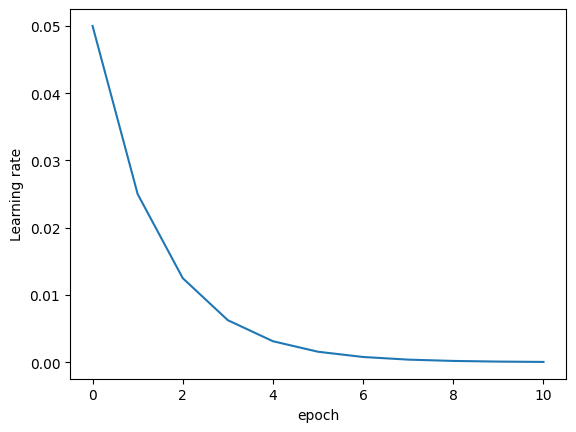

In [316]:
plt.plot(lr_1)
plt.xlabel('epoch')
plt.ylabel('Learning rate')

接下来，我们放缓学习率衰减速率，进行学习率调度建模实验。

## 3.LambadaLR学习率调度实验

### 3.1 前期准备与匿名函数定义

在实验开始前，我们需要将之前定义的fit_rec函数再次进行改写，新函数需要包含学习率调度相关方法。

In [317]:
def fit_rec_sc(net, 
            criterion, 
            optimizer, 
            train_data, 
            test_data,
            scheduler, 
            epochs = 3, 
            cla = False, 
            eva= mse_cal):
    """加入学习率调度后的模型训练函数(记录每一次遍历后模型评估指标)
    
    param net: 待训练模型
    param criterion: 损失函数
    param optimizer: 优化算法
    param batchdata: 训练数据集
    param scheduler: 学习率调度器
    param cla: 是否是分类问题
    param epochs: 遍历数据次数
    param eva: 模型评估方法
    """
    train_1 = []
    test_1 = []
    for epoch in range(epochs):
        net.train()
        for X, y in train_data:
            if cla == True:
                y = y.flatten().long()      # 如果是分类问题，需要对y进行整数转化
            yhat = net.forward(X)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        net.eval()
        train_1.append(eva(train_data, net).detach())
        test_1.append(eva(test_data, net).detach())
    return train_1, test_1

同样，该函数需要写入torchLearning.py文件中。接下来，我们定义一个衰减速度更加缓慢的学习率调度器。

In [318]:
lr_lambda = lambda epoch: 0.95 ** epoch

In [319]:
# 第一轮迭代时
lr_lambda(0)

1.0

In [320]:
# 第二轮迭代时
lr_lambda(1)

0.95

> 相当于每轮迭代学习率衰减5%

In [321]:
# 设置随机数种子
torch.manual_seed(24)

# 实例化模型
tanh_model1 = net_class2(act_fun= torch.tanh, in_features= 5, BN_model= 'pre')

In [322]:
# 创建优化器
optimizer = torch.optim.SGD(tanh_model1.parameters(), lr= 0.05)

In [323]:
# 创建学习率调度器
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

### 3.2 模型训练与结果比较

In [324]:
# 进行模型训练
train_l, test_l = fit_rec_sc(net= tanh_model1,
                             criterion= nn.MSELoss(),
                             optimizer= optimizer,
                             train_data= train_loader,
                             test_data= test_loader,
                             scheduler= scheduler,
                             epochs= 60,
                             cla= False,
                             eva= mse_cal)

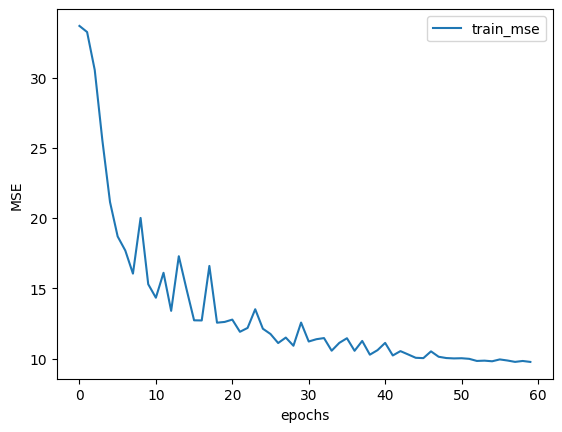

In [325]:
plt.plot(train_l, label= 'train_mse')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

简单验证学习率最终调整结果。

In [326]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.002303489949347597,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [338]:
lr_lambda(60)* 0.05

0.002303489949347597

当然，我们也可继续进行实验，对比恒定学习率时计算结果

* 对比恒定学习率为0.03时模型训练结果

In [328]:
# 设置随机数种子
torch.manual_seed(24)

# 实例化模型
tanh_model1 = net_class2(act_fun= torch.tanh, in_features= 5, BN_model= 'pre')

In [329]:
# 进行模型训练
train_l3, test_l3 = fit_rec(net= tanh_model1,
                             criterion= nn.MSELoss(),
                             optimizer= optim.SGD(tanh_model1.parameters(), lr= 0.03),
                             train_data= train_loader,
                             test_data= test_loader,
                             epochs= 60,
                             cla= False,
                             eva= mse_cal)

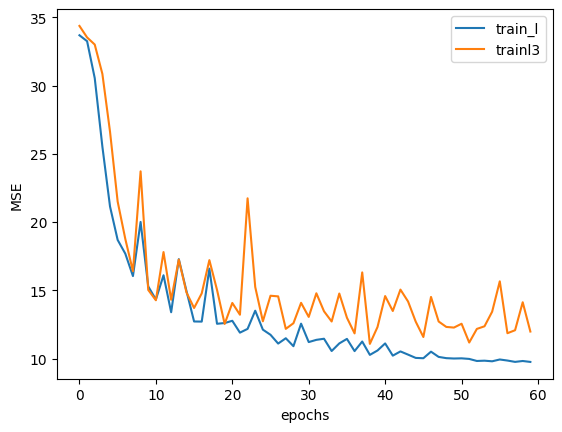

In [330]:
plt.plot(train_l, label = 'train_l')
plt.plot(train_l3, label = 'trainl3')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

我们发现，相比恒定学习为0.03的模型，加入学习率调度策略的模型，模型收敛效果更好、迭代更加平稳，且收敛速度较快。

* 对比恒定学习率为0.01时模型训练结果

In [331]:
# 设置随机数种子
torch.manual_seed(24)

# 实例化模型
tanh_model1 = net_class2(act_fun= torch.tanh, in_features= 5, BN_model= 'pre')

In [332]:
# 进行模型训练
train_l1, test_l1 = fit_rec(net= tanh_model1,
                             criterion= nn.MSELoss(),
                             optimizer= optim.SGD(tanh_model1.parameters(), lr= 0.01),
                             train_data= train_loader,
                             test_data= test_loader,
                             epochs= 60,
                             cla= False,
                             eva= mse_cal)

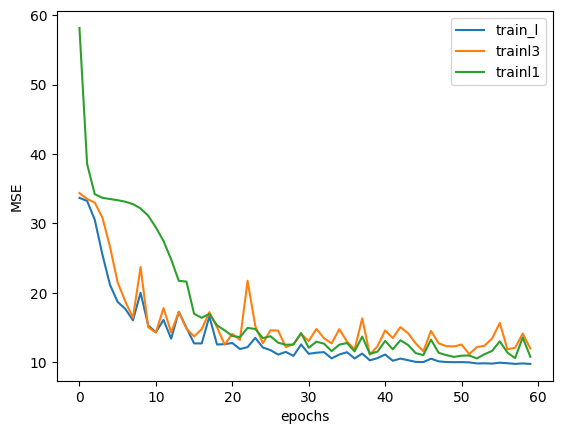

In [333]:
plt.plot(train_l, label = 'train_l')
plt.plot(train_l3, label = 'trainl3')
plt.plot(train_l1, label = 'trainl1')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

我们发现，相比恒定学习率为0.01的模型，拥有学习率调度的模型结果更优秀。

* 对比Lesson 15.1 中学习率调度模型

前30 epochs lr为0.03；后30 epochs 时 lr 为0.01

In [334]:
# 设置随机数种子
torch.manual_seed(24)

# 实例化模型
tanh_model1 = net_class2(act_fun= torch.tanh, in_features= 5, BN_model= 'pre')

In [335]:
# 创建用于保存记录结果的空列表容器
train_mse = []
test_mse = []

# 创建可以捕捉手动输入数据的模型训练流程
while input('Do you want to continue the iteration? [y/n]') == 'y':     # 询问是否继续迭代
    epochs = int(input('Number of epochs:'))                            # 下一轮迭代遍历几次数据
    lr = float(input('Update learning rate:'))                          # 设置下一轮迭代的学习率
    train_1, test_1 = fit_rec(net= tanh_model1,
                              criterion= nn.MSELoss(),
                              optimizer= optim.SGD(tanh_model1.parameters(), lr= lr),
                              train_data= train_loader,
                              test_data= test_loader,
                              epochs= epochs,
                              cla= False,
                              eva= mse_cal)
    train_mse.extend(train_1)
    test_mse.extend(test_1)

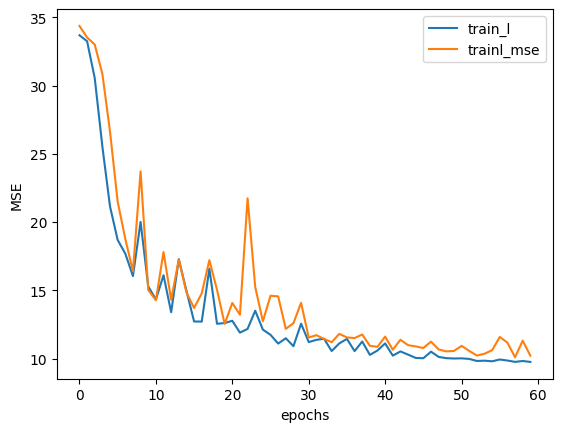

In [336]:
plt.plot(train_l, label = 'train_l')
plt.plot(train_mse, label = 'trainl_mse')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend(loc = 1)

很明显，由于上一节的模型是0.03学习率模型和0.01学习率模型简单叠加的结果，在恒定学习率模型效果均不如本节模型的情况下，上一节的模型学习率调度策略也无法有更好的表现。

但是，令人惊讶的是，在训练了60轮之后，LambdaLR模型最终学习率在0.02附近，相比上述0.01学习率模型更加平稳。但是更大的学习率为何会收敛至一个更小的值，并且从结果上来看，整个迭代过程也比0.01学习率模型更加平稳。当然，如果进一步实验，我们也能够发现该模型比恒定学习率为0.02或者0.025模型效果更好。

In [340]:
lr_lambda(60) * 0.05

0.002303489949347597

这其实说明损失函数在超平面空间的图像比一般的想象要复杂的多，很多时候并不是越靠近全域最小值点附近的通道就越窄，会导致迭代过程落入局部最小值陷阱的学习率大小取值也只是绝对概念。正是由于损失函数的复杂性，才导致很多时候我们认为神经网络的内部训练是个“黑箱”，才进一步导致神经网络的模型训练往往以模型结果为最终依据，这也是神经网络优化算法会诞生诸多基本理论层面比较扎实，但却找不到具体能够证明优化效果的理论依据的方法。

不过，针对此类方法，和此前介绍的Batch Normalization一样，尽管理论层面无法具体整体优化效果，但对于使用者来说仍然在了解底层基本原理基础上积累使用经验或者调参经验。因此在后续的课程中，我们将在继续介绍其它学习率优化方法的同时，通过大量的实践来快速积累使用经验，并且在更多事实基础上找到解释和理解的角度。